In [95]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
from afqinsight.nn.pt_models import Conv1DAutoencoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [96]:
# FA FLATTENED DATASET
# NON VARIATIONAL 
# CONVOLUTIONAL AUTOENCODER
# TESTING LATENT AND DROPOUT SIMULTATENTOUSLY 

In [97]:
import sys 
sys.path.insert(1, '/Users/samchou/AFQ-Insight-Autoencoder-Experiments/AFQ-Insight-Autoencoder-Experiments/Experiment_Utils')
# sys.path.insert(1, '/mmfs1/gscratch/nrdg/samchou/AFQ-Insight-Autoencoder-Experiments/Experiment_Utils')
from utils import train_variational_autoencoder, train_autoencoder, select_device, prep_fa_dataset, prep_first_tract_data, prep_fa_flattned_data
from models import Conv1DVariationalAutoencoder_fa

In [98]:
device = select_device()

Using device: mps

Using MPS backend on macOS. (Detailed memory info may not be available.)


In [99]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=128)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100

value_counts = {}
for x in range(len(train_loader.dataset)):
    value = train_loader.dataset[x][1][2]  # Get the tensor value
    value_counts[value.item()] = value_counts.get(value.item(), 0) + 1
print(f"Counts of each tensor value: {value_counts}")



File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


Counts of each tensor value: {4.0: 179, 0.0: 489, 3.0: 485, 1.0: 41}


In [111]:
torch_dataset, all_tracts_train_loader, all_tracts_test_loader, all_tracts_val_loader = prep_fa_flattned_data(dataset, batch_size=128)

torch_dataset, fa_train_loader, fa_test_loader, fa_val_loader = prep_fa_dataset(dataset, batch_size=128)

In [112]:
print("fa train loader", all_tracts_train_loader.dataset[0][1][0])

fa train loader tensor(6.0222)


In [102]:

value_counts = {}
for x in range(len(all_tracts_train_loader.dataset)):
    value = all_tracts_train_loader.dataset[x][1][2]  # Get the tensor value
    value_counts[value.item()] = value_counts.get(value.item(), 0) + 1
print(f"Counts of each tensor value: {value_counts}")

for x in range(len(fa_train_loader.dataset)):
    value = fa_train_loader.dataset[x][1][2]  # Get the tensor value
    value_counts[value.item()] = value_counts.get(value.item(), 0) + 1
print(f"Counts of each tensor value: {value_counts}")

Counts of each tensor value: {3.0: 23568, 0.0: 23712, 4.0: 7776, 1.0: 2256}
Counts of each tensor value: {3.0: 24046, 0.0: 24210, 4.0: 7947, 1.0: 2303}


In [103]:
print(len(train_loader.dataset[0]))
print(train_loader.dataset[0][0].shape)

2
torch.Size([48, 100])


In [104]:
print(all_tracts_train_loader.dataset[0][1][0]) #this is 

tensor(10.9884)


In [105]:
# Print first 10 samples from train loader
for i, (x, labels) in enumerate(all_tracts_train_loader):
    if i >= 10:  # Only print first 10
        break
    print(x.shape)
    print("label shape", labels.shape)
    print(f"Sample {i}:", labels)
    print("age", labels[0][0])
    print("sex", labels[0][1])
    print("group", labels[0][2])


torch.Size([128, 1, 50])
label shape torch.Size([128, 3])
Sample 0: tensor([[ 5.5869,  1.0000,  0.0000],
        [ 8.2284,  1.0000,  4.0000],
        [ 7.7685,  1.0000,  0.0000],
        [ 7.9085,  0.0000,  0.0000],
        [ 7.6207,  1.0000,  3.0000],
        [12.4481,  1.0000,  0.0000],
        [ 8.5302,  0.0000,  3.0000],
        [10.2275,  1.0000,  3.0000],
        [11.0976,  1.0000,  3.0000],
        [ 9.3103,  1.0000,  0.0000],
        [ 7.4398,  0.0000,  0.0000],
        [ 7.1939,  1.0000,  3.0000],
        [14.3613,  0.0000,  3.0000],
        [10.9641,  0.0000,  0.0000],
        [ 7.3824,  1.0000,  0.0000],
        [ 9.1183,  0.0000,  4.0000],
        [ 5.7781,  1.0000,  3.0000],
        [ 5.2118,  0.0000,  0.0000],
        [ 9.9867,  1.0000,  0.0000],
        [11.9086,  0.0000,  0.0000],
        [ 6.3612,  1.0000,  3.0000],
        [13.5212,  1.0000,  0.0000],
        [ 5.8107,  0.0000,  0.0000],
        [16.8362,  1.0000,  3.0000],
        [ 5.8465,  1.0000,  0.0000],
       

In [106]:
import pandas as pd
import torch

latent_dims = [2, 4, 8, 16, 32, 64, 100]
dropout_values = [0.0, 0.1, 0.5]
models = {}
results = {}

for dropout in dropout_values:
    for latent_dim in latent_dims:

        print(f"Training Autoencoder with Latent Dimension: {latent_dim} and Dropout: {dropout}")
        
        # 1) Train the model and store results
        test_model = Conv1DVariationalAutoencoder_fa(latent_dims=latent_dim, dropout=dropout).to(device)
        training_results = train_variational_autoencoder(
            model=test_model,
            train_data=all_tracts_train_loader,
            val_data=all_tracts_val_loader,
            epochs=500,   # or more epochs
            device=device
        )
        
        models[latent_dim, dropout] = test_model
        results[latent_dim, dropout] = training_results
        
        print(f"Completed training for latent_dim={latent_dim}, Best Val RMSE: {training_results['best_val_rmse']:.4f}")

        # 2) Convert Tensors in training_results to CPU floats
        keys_to_convert = [
            "train_rmse_per_epoch",
            "val_rmse_per_epoch",
            "train_kl_per_epoch",
            "val_kl_per_epoch",
            "train_recon_per_epoch",
            "val_recon_per_epoch",
            "train_loss_per_epoch",
            "val_loss_per_epoch"
        ]
        for key in keys_to_convert:
            if key in training_results:
                new_list = []
                for val in training_results[key]:
                    if isinstance(val, torch.Tensor):
                        new_list.append(float(val.cpu().item()))
                    else:
                        new_list.append(float(val))
                training_results[key] = new_list

        # If best_val_rmse might be a tensor:
        if isinstance(training_results.get("best_val_rmse"), torch.Tensor):
            training_results["best_val_rmse"] = float(training_results["best_val_rmse"].cpu().item())

        # 3) Build your DataFrames and save them with unique filenames
        num_epochs = len(training_results["train_rmse_per_epoch"])
        
        # Per-epoch metrics
        df_epochs = pd.DataFrame({
            "epoch": range(1, num_epochs + 1),
            "train_rmse": training_results["train_rmse_per_epoch"],
            "val_rmse": training_results["val_rmse_per_epoch"],
            "train_kl": training_results["train_kl_per_epoch"],
            "val_kl": training_results["val_kl_per_epoch"],
            "train_recon_loss": training_results["train_recon_per_epoch"],
            "val_recon_loss": training_results["val_recon_per_epoch"],
            "train_loss": training_results["train_loss_per_epoch"],
            "val_loss": training_results["val_loss_per_epoch"]
        })
        
        # Use f-strings to create unique filenames
        df_epochs.to_csv(f"vae_per_epoch_metrics_ld{latent_dim}_dr{dropout}.csv", index=False)
        
        # Summary row
        df_summary = pd.DataFrame([
            {"best_val_rmse": training_results["best_val_rmse"]}
        ])
        df_summary.to_csv(f"vae_summary_ld{latent_dim}_dr{dropout}.csv", index=False)


Training Autoencoder with Latent Dimension: 2 and Dropout: 0.0


/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [ ]:
latent_dims = [2, 4, 8, 16, 32, 64, 100]
dropout_values = [0.0, 0.1, 0.5]
df_best_val = pd.DataFrame(index=dropout_values, columns=latent_dims)

# Populate the DataFrame with the best validation RMSE values
for latent_dim in latent_dims:
    for dropout in dropout_values:
        print(f"Latent Dim: {latent_dim}, Dropout: {dropout}")  
        key = (latent_dim, dropout)
        if key in results:
            best_val_loss = results[key]["best_val_rmse"]
            df_best_val.loc[dropout, latent_dim] = best_val_loss
        else:
            print(f"Key {key} not found in results.")
            # Handle missing key, e.g., set a default value
            df_best_val.loc[dropout, latent_dim] = np.nan  # or any other default


# Convert the values to floats (if they aren't already)
df_best_val = df_best_val.astype(float)

# Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(df_best_val, annot=True, fmt=".3f", cmap="viridis")
# plt.xlabel("Latent Dimensions")
# plt.ylabel("Dropout Rate")
# plt.title("Best Validation RMSE for Each Dropout and Latent Dimension Combination")
# plt.show()

#Saving the heatmap to a file, for batch scripting 
plt.figure(figsize=(10, 8))
sns.heatmap(df_best_val, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("Latent Dimensions")
plt.ylabel("Dropout Rate")
plt.title("Best Validation RMSE for Each Dropout and Latent Dimension Combination")
plt.savefig("heatmap_conv_vae_combined_fa_flattened.png")  
plt.close()  

Latent Dim: 2, Dropout: 0.0
Latent Dim: 2, Dropout: 0.1
Latent Dim: 2, Dropout: 0.5
Latent Dim: 4, Dropout: 0.0
Latent Dim: 4, Dropout: 0.1
Latent Dim: 4, Dropout: 0.5
Latent Dim: 8, Dropout: 0.0
Latent Dim: 8, Dropout: 0.1
Latent Dim: 8, Dropout: 0.5
Latent Dim: 16, Dropout: 0.0
Latent Dim: 16, Dropout: 0.1
Latent Dim: 16, Dropout: 0.5
Latent Dim: 32, Dropout: 0.0
Latent Dim: 32, Dropout: 0.1
Latent Dim: 32, Dropout: 0.5
Latent Dim: 64, Dropout: 0.0
Latent Dim: 64, Dropout: 0.1
Latent Dim: 64, Dropout: 0.5
Latent Dim: 100, Dropout: 0.0
Latent Dim: 100, Dropout: 0.1
Latent Dim: 100, Dropout: 0.5


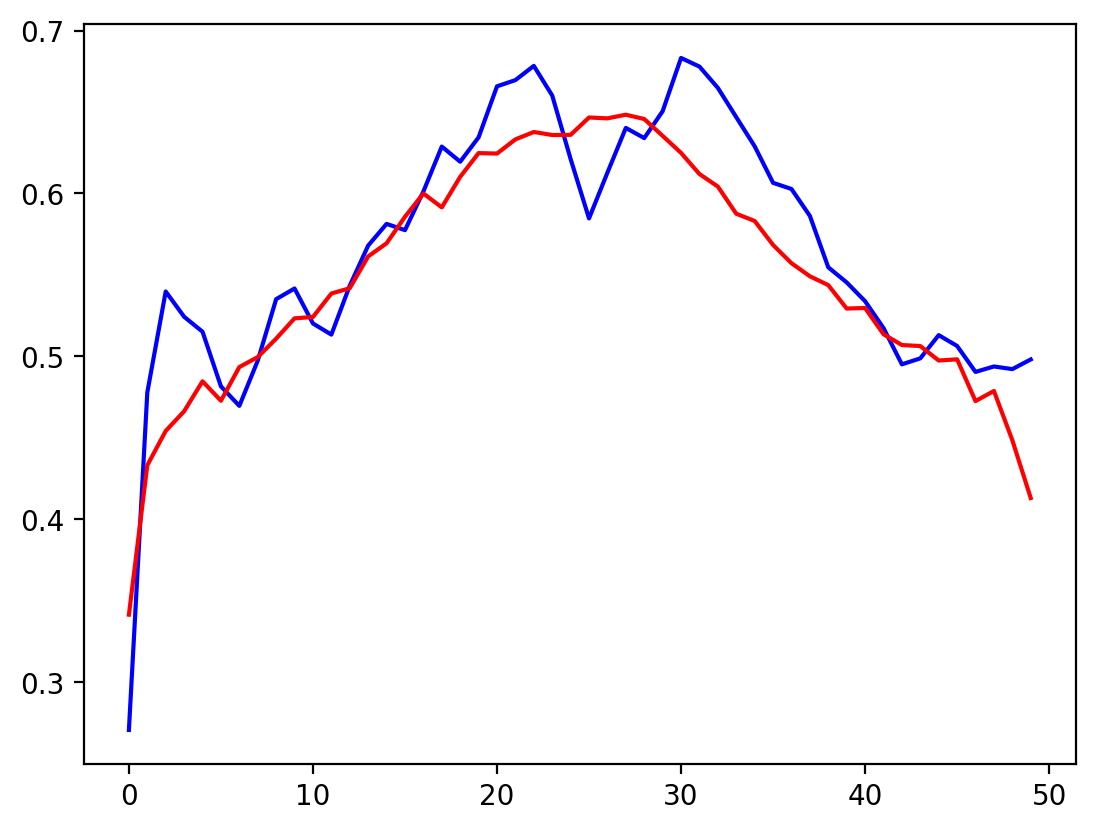

In [ ]:
#selecting the model with 16 latent dimensions, 0.1 dropout
sample = all_tracts_test_loader.dataset[0][0][0:1].unsqueeze(0).to(device)
output = models[16, 0.1](sample)

# Assuming the first element of the tuple is the reconstruction:
reconstructed = output[0]

orig = sample.cpu().detach().numpy()
recon = reconstructed.cpu().detach().numpy()

plt.plot(orig.flatten()[0:100], color='blue', label='Original')
plt.plot(recon.flatten()[0:100], color='red', label='Reconstructed')
# plt.figure()
# plt.plot(orig.flatten()[0:100], label="Original")
# plt.plot(recon.flatten()[0:100], label="Reconstructed")
# plt.legend()
# plt.title("Original vs. Reconstructed (First 100 Points)")
# plt.savefig("ogvsrecon_conv_vae_combined_fa_flattened.png")  
# plt.close()